In [107]:
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pandas import DataFrame

from msc import config
from msc.data_utils import get_time_as_str
from msc.dataset import UniformDataset, SeizuresDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the model

In [108]:
class EEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(EEGGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()



In [109]:
model = EEGGPModel([], [], likelihood)
model

EEGGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [110]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


## Sample from the prior

In [111]:
times = torch.linspace(1, 10, 1000)
times.shape

torch.Size([1000])

In [112]:
model(times)

MultivariateNormal(loc: torch.Size([1000]))

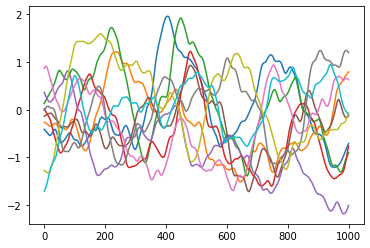

In [113]:
for i in range(10):
    plt.plot(model(times).sample())

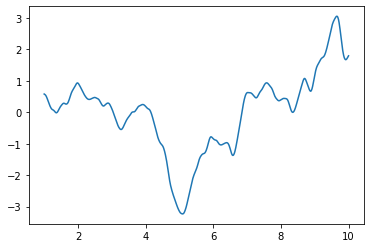

In [114]:
train_x = times
sample = model(times).sample()
plt.plot(train_x, (sample - sample.mean()) / (torch.var(sample - sample.mean())))

## Define training loop

In [115]:
def training_loop(train_x, train_y, num_iters=50, lr=0.01):
    model = EEGGPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, num_iters, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    params = pd.DataFrame(model.named_parameters(), columns=["param_name", "param_value"])
    params['param_value'] = params.param_value.apply(lambda x: x.item())
    return params


In [116]:
def train_model_multiple_times(train_x, train_y, num_iters=50, lr=0.01):
    params_results = []
    for i in range(train_y.shape[0]):
        print(f"**** training loop {i=} ****")
        results = training_loop(train_x, train_y[i], num_iters=num_iters, lr=lr)
        results["sample_id"] = i
        params_results.append(results)
    results_df = pd.concat(params_results)
    return results_df

## Train on single sample

In [117]:
training_loop(train_x, sample)

Iter 1/50 - Loss: 0.785   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.783   lengthscale: 0.698   noise: 0.688
Iter 3/50 - Loss: 0.778   lengthscale: 0.703   noise: 0.683
Iter 4/50 - Loss: 0.780   lengthscale: 0.708   noise: 0.678
Iter 5/50 - Loss: 0.781   lengthscale: 0.713   noise: 0.673
Iter 6/50 - Loss: 0.759   lengthscale: 0.718   noise: 0.669
Iter 7/50 - Loss: 0.761   lengthscale: 0.723   noise: 0.664
Iter 8/50 - Loss: 0.759   lengthscale: 0.728   noise: 0.659
Iter 9/50 - Loss: 0.756   lengthscale: 0.733   noise: 0.654
Iter 10/50 - Loss: 0.758   lengthscale: 0.738   noise: 0.649
Iter 11/50 - Loss: 0.755   lengthscale: 0.743   noise: 0.644
Iter 12/50 - Loss: 0.747   lengthscale: 0.748   noise: 0.640
Iter 13/50 - Loss: 0.737   lengthscale: 0.753   noise: 0.635
Iter 14/50 - Loss: 0.740   lengthscale: 0.758   noise: 0.630
Iter 15/50 - Loss: 0.731   lengthscale: 0.763   noise: 0.626
Iter 16/50 - Loss: 0.732   lengthscale: 0.768   noise: 0.621
Iter 17/50 - Loss: 0.732   length

,param_name,param_value
0,likelihood.noise_covar.raw_noise,-0.505822
1,covar_module.raw_outputscale,-0.349338
2,covar_module.base_kernel.raw_lengthscale,0.383890


## Load Uniform Data Samples

In [118]:
# dataset.samples_df.dropna(subset=['window_id'])

In [119]:
data_dir = r"C:\Users\noam\Repositories\noamsgl\msc\results\epilepsiae\UNIFORM\20220106T165558"
dataset = UniformDataset(data_dir)
train_x = dataset.get_train_x()
print("warning, results incomplete")
train_y = dataset.get_train_y(num_channels=1)[:10]

loading
done loading
warning, results incomplete


## MLE Hyperparameter estimation

In [120]:
params = train_model_multiple_times(train_x, train_y)

**** training loop i=0 ****
Iter 1/50 - Loss: 0.573   lengthscale: 0.693   noise: 0.472
Iter 2/50 - Loss: 0.565   lengthscale: 0.698   noise: 0.468
Iter 3/50 - Loss: 0.560   lengthscale: 0.703   noise: 0.465
Iter 4/50 - Loss: 0.560   lengthscale: 0.708   noise: 0.461
Iter 5/50 - Loss: 0.555   lengthscale: 0.713   noise: 0.457
Iter 6/50 - Loss: 0.549   lengthscale: 0.718   noise: 0.453
Iter 7/50 - Loss: 0.552   lengthscale: 0.724   noise: 0.450
Iter 8/50 - Loss: 0.536   lengthscale: 0.729   noise: 0.446
Iter 9/50 - Loss: 0.541   lengthscale: 0.734   noise: 0.443
Iter 10/50 - Loss: 0.536   lengthscale: 0.739   noise: 0.439
Iter 11/50 - Loss: 0.531   lengthscale: 0.744   noise: 0.436
Iter 12/50 - Loss: 0.523   lengthscale: 0.749   noise: 0.432
Iter 13/50 - Loss: 0.525   lengthscale: 0.755   noise: 0.428
Iter 14/50 - Loss: 0.525   lengthscale: 0.760   noise: 0.425
Iter 15/50 - Loss: 0.513   lengthscale: 0.765   noise: 0.422
Iter 16/50 - Loss: 0.508   lengthscale: 0.771   noise: 0.418
Iter 

<AxesSubplot:ylabel='Frequency'>

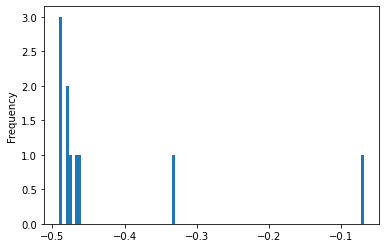

In [121]:
# plot output scale distribution
params.groupby('param_name').get_group('covar_module.raw_outputscale').param_value.plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

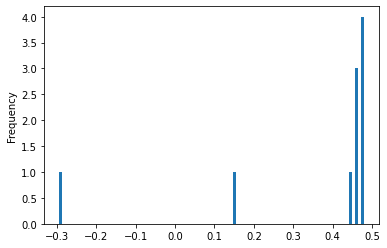

In [122]:
# plot input scale distribution
params.groupby('param_name').get_group('covar_module.base_kernel.raw_lengthscale').param_value.plot(kind='hist',
                                                                                                    bins=100)

<AxesSubplot:ylabel='Frequency'>

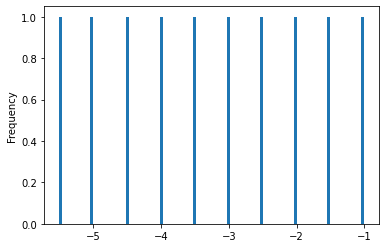

In [123]:
# plot noise distribution
params.groupby('param_name').get_group('likelihood.noise_covar.raw_noise').param_value.plot(kind='hist', bins=100)

In [124]:
# # scatter plot
# params.pivot(index='sample_id', columns='param_name', values='param_value').plot.scatter(
#     x="covar_module.base_kernel.raw_lengthscale", y="covar_module.raw_outputscale")

In [125]:
params

,param_name,param_value,sample_id
0,likelihood.noise_covar.raw_noise,-1.010396,0
1,covar_module.raw_outputscale,-0.490407,0
2,covar_module.base_kernel.raw_lengthscale,0.475375,0
0,likelihood.noise_covar.raw_noise,-1.513043,1
1,covar_module.raw_outputscale,-0.489963,1
2,covar_module.base_kernel.raw_lengthscale,0.475683,1
0,likelihood.noise_covar.raw_noise,-2.015249,2
1,covar_module.raw_outputscale,-0.487898,2
2,covar_module.base_kernel.raw_lengthscale,0.474392,2
0,likelihood.noise_covar.raw_noise,-2.514141,3


In [126]:
params.to_csv(f'results_{dataset.name}_{get_time_as_str()}.csv')

## Load Seizures Dataset

In [ ]:
seizures_dataset_dir = r"C:\Users\noam\Repositories\noamsgl\msc\results\epilepsiae\SEIZURES\20220103T101554"
seizures_dataset = SeizuresDataset(seizures_dataset_dir)
seizures_train_x = seizures_dataset.get_train_x(crop_seconds=1000 / 256)
print("warning results incomplete")
seizures_train_y = seizures_dataset.get_train_y(num_channels=1, crop_seconds=1000 / 256, delay_seconds=10)[:10]

loading data
loading
done loading


In [128]:
seizure_params = train_model_multiple_times(seizures_train_x, seizures_train_y)

**** training loop i=0 ****
Iter 1/50 - Loss: -1.463   lengthscale: 0.693   noise: 0.004
Iter 2/50 - Loss: -1.469   lengthscale: 0.688   noise: 0.004
Iter 3/50 - Loss: -1.437   lengthscale: 0.683   noise: 0.004
Iter 4/50 - Loss: -1.448   lengthscale: 0.678   noise: 0.004
Iter 5/50 - Loss: -1.441   lengthscale: 0.674   noise: 0.004
Iter 6/50 - Loss: -1.466   lengthscale: 0.669   noise: 0.004
Iter 7/50 - Loss: -1.456   lengthscale: 0.665   noise: 0.004
Iter 8/50 - Loss: -1.459   lengthscale: 0.660   noise: 0.004
Iter 9/50 - Loss: -1.467   lengthscale: 0.656   noise: 0.004
Iter 10/50 - Loss: -1.458   lengthscale: 0.651   noise: 0.004
Iter 11/50 - Loss: -1.457   lengthscale: 0.647   noise: 0.004
Iter 12/50 - Loss: -1.477   lengthscale: 0.643   noise: 0.004
Iter 13/50 - Loss: -1.464   lengthscale: 0.638   noise: 0.004
Iter 14/50 - Loss: -1.466   lengthscale: 0.634   noise: 0.004
Iter 15/50 - Loss: -1.481   lengthscale: 0.629   noise: 0.004
Iter 16/50 - Loss: -1.474   lengthscale: 0.625   no

## Plot Params

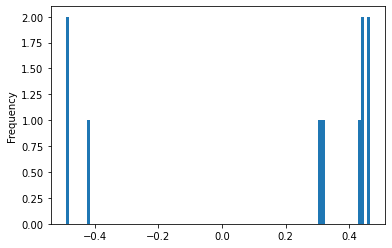

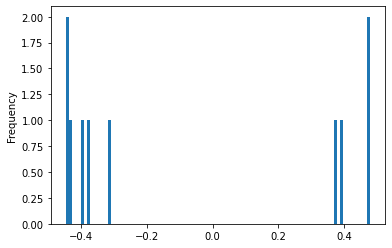

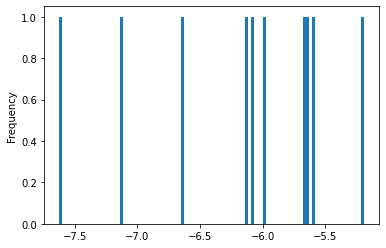

In [129]:
def plot_param_results(params: DataFrame) -> None:
    # plot output scale distribution
    params.groupby('param_name').get_group('covar_module.raw_outputscale').param_value.plot(kind='hist', bins=100)
    plt.show()

    # plot input scale distribution
    params.groupby('param_name').get_group('covar_module.base_kernel.raw_lengthscale').param_value.plot(kind='hist', bins=100)
    plt.show()

    # plot noise distribution
    params.groupby('param_name').get_group('likelihood.noise_covar.raw_noise').param_value.plot(kind='hist', bins=100)
    plt.show()
    return None

plot_param_results(seizure_params)

## Save to csv

In [132]:
results_fpath = f"{config['PATH']['LOCAL']['RESULTS']}/params/results_{seizures_dataset.name}_{get_time_as_str()}.csv"
seizure_params.to_csv(results_fpath)